# Part 2: Machine Learning - Regression models

Part 2: Machine Learning - Regression models solves the problem of predicting the pollution emitted by vehicles based on different vehicle measurements, such as highway fuel consumption, city fuel consumption, engine size, or the number of gears, among others. This notebook uses the preprocessed dataset created as output of the first part of the portofolio. Specifically, it has 6,281 rows, 7 features and 1 response variable to be predicted.

- Debajyoti Podder (2020). Dataset: CO2 Emission by Vehicles - Amount of CO2 emissions by a vehicle depending on their various features. URL: [https://www.kaggle.com/datasets/debajyotipodder/co2-emission-by-vehicles](https://www.kaggle.com/datasets/debajyotipodder/co2-emission-by-vehicles)

## Data Preprocessing
The following cells import the required packages and defines functions to enhance code readability and prevent duplication."

In [1]:
# Kagglehub is used to directly download the data file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

# Machine Learning regression models and measurements
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
import statsmodels.api as sm

# Display options
pd.options.display.float_format = "{:,.4f}".format

In [2]:
# Functions used to pre-process the data as done within the first notebook
def add_gears_trans(df_raw):
  """
  Function to add the features gears and transmission to the dataset.

  Parameters:
  df_raw (pandas dataframe): raw dataset.
  """
  gears = df_raw["Transmission"].str[-1]; transmission = df_raw["Transmission"].str[:-1]

  # We need to correct the values for the AV category and cars with 10 gears (A10, AV10, AS10).
  transmission[gears == "0"] = transmission[gears == "0"].str[:-1]
  transmission[gears == "V"] = transmission[gears == "V"] + "V"
  gears[gears == "0"] = 10; gears[gears == "V"] = 0 # Remove extra 1s and add a V

  df_raw["Gears"] = gears.astype(int); df_raw["Transmission"] = transmission
  return(df_raw)

def process_data(df_raw):
  """
  Function to pre-process the data as done in the first notebook, including
  droping certain observations and variables, adding the new features,
  feature normalization and recoding the categorical variables to numerical values.

  Parameters:
  df_raw (pandas dataframe): raw dataset.
  """
  drop_vars=["Fuel Consumption Comb (mpg)", "Fuel Consumption Comb (L/100 km)",
             "Make", "Model", "Vehicle Class"]
  num_vars = ["Fuel Consumption City (L/100 km)", "Fuel Consumption Hwy (L/100 km)",
              "Engine Size(L)", "Cylinders", "Gears"]

  # Removal of certain observations and variables. Identification of rows
  remove_obs_cond = (df_raw.duplicated()) | (df_raw["Fuel Type"]=="N")
  df_processed = add_gears_trans(df_raw.copy()).loc[~remove_obs_cond,]
  df_processed.index = df_processed["Make"]+" - "+df_processed["Model"]
  df_processed = df_processed.drop(columns=drop_vars)

  # Feature normalization and recoding the categorical variables to numerical values
  cars_df_nums = df_processed[num_vars]
  df_processed[num_vars] = pd.DataFrame(StandardScaler().fit_transform(cars_df_nums),
                                        columns=cars_df_nums.columns, index=cars_df_nums.index)
  df_processed[["Transmission","Fuel Type"]] = OrdinalEncoder().fit_transform(
      df_processed[["Transmission","Fuel Type"]])
  return(df_processed)

# Functions used to measure the performance of the ML models
def get_error_measurements(train_set, test_set, fitted_model, print_results=True):
  """
  Get the R2 and MSE of the fitted models in the training and test set

  Parameters:
  train_set (list: features, response): Train data list (features X, response y).
  test_set (list: features, response): Test data list (features X, response y).
  fitted_model (scikit-learn or statsmodel fitted model): Model fitted to train data.
  print_results (bool): Should results be printed on screen?
  """
  train_X, train_y = train_set; test_X, test_y = test_set
  train_pred = fitted_model.predict(train_X)
  test_pred = fitted_model.predict(test_X)

  acc_train = r2_score(train_y, train_pred)
  acc_test = r2_score(test_y, test_pred)
  mse_train = mean_squared_error(train_y, train_pred)
  mse_test = mean_squared_error(test_y, test_pred)

  if print_results:
    print(f"R2 :\tTrain = {acc_train:.4f} \t\t Test = {acc_test:.4f}")
    print(f"MSE:\tTrain = {mse_train:.4f} \t Test = {mse_test:.4f}")
  return(pd.DataFrame({"Train-R2": [acc_train],  "Test-R2": [acc_test],
                       "Train-MSE": [mse_train], "Test-MSE": [mse_test]}))

def plot_predicted_vs_actual(y_true, y_pred, title="Predicted vs Actual"):
    """
    Plots predicted values against actual values in a regression problem.

    Parameters:
    y_true (number array): Actual values.
    y_pred (number array): Predicted values.
    title (str): Title of the plot.
    """
    plt.scatter(y_true, y_pred, alpha=0.5, color='blue', label='Predicted vs Actual')
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Identity (y=x)')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title, loc="left")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')

def plot_residuals(y_true, y_pred, title="Residuals Plot"):
    """
    Plots residuals (errors) of predicted vs actual values in a regression problem.

    Parameters:
    y_true (number array): Actual values.
    y_pred (number array): Predicted values.
    title (str): Title of the plot.
    """
    residuals = np.array(y_true) - np.array(y_pred)
    plt.scatter(range(len(residuals)), residuals, alpha=0.5, color='green', label='Residuals')
    plt.axhline(y=0, color='orange', linestyle='--', label='Zero Error Line')
    plt.ylim(-300, 300) # Common axis limits for easier comparisons
    plt.xlabel('Index')
    plt.ylabel('Residual (Actual - Predicted)')
    plt.title(title, loc="left")
    plt.legend()
    plt.grid(True)

def plot_regression_diagnostics(y_true, y_pred, title_pred_vs_act="Predicted vs Actual",
                               title_residuals="Residuals Plot", fig_title="Regression Diagnostics"):
    """
    Creates a figure with two subplots: Predicted vs Actual and Residuals.

    Parameters:
    y_true (number array): Actual values.
    y_pred (number array): Predicted values.
    title_pred_vs_act (str): Title for predicted vs actual subplot.
    title_residuals (str): Title for residuals subplot.
    fig_title (str): Overall figure title.
    """
    plt.figure(figsize=(12, 5))

    # Subplot 1: Predicted vs Actual
    plt.subplot(1, 2, 1)
    plot_predicted_vs_actual(y_true, y_pred, title=title_pred_vs_act)

    # Subplot 2: Residuals
    plt.subplot(1, 2, 2)
    plot_residuals(y_true, y_pred, title=title_residuals)

    # Overall figure title
    plt.suptitle(fig_title, fontsize=16, x=0.2)
    plt.tight_layout(rect=[0, 0, 1, 0.975])  # Adjust layout to fit suptitle
    plt.show()

The following cell loads the dataset as a DataFrame, and pre-processes it as done within the first notebook (this includes the feature normalization and recoding the categorical variables to numerical values). Moreover, it divides the variables into predictive features (`X`) and reponse variable (`y`).

In [3]:
datapath = kagglehub.dataset_download("debajyotipodder/co2-emission-by-vehicles", path='CO2 Emissions_Canada.csv')
df_processed = process_data(pd.read_csv(datapath, header=0, sep=',', quotechar='"'))
complete_X = df_processed.copy().loc[:, df_processed.columns.difference(["CO2 Emissions(g/km)"])]
complete_y = df_processed["CO2 Emissions(g/km)"]

df_processed

,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),CO2 Emissions(g/km),Gears
ACURA - ILX,-0.8510,-0.8768,2.0000,3.0000,-0.7627,-1.0402,196,-0.9035
ACURA - ILX,-0.5580,-0.8768,4.0000,3.0000,-0.3968,-0.6014,221,-0.3404
ACURA - ILX HYBRID,-1.2172,-0.8768,3.0000,3.0000,-1.8604,-1.4351,136,0.2227
ACURA - MDX 4WD,0.2478,0.2064,2.0000,3.0000,0.0254,0.0129,255,-0.3404
ACURA - RDX AWD,0.2478,0.2064,2.0000,3.0000,-0.1435,-0.1626,244,-0.3404
...,...,...,...,...,...,...,...,...
VOLVO - XC40 T5 AWD,-0.8510,-0.8768,2.0000,3.0000,-0.5375,-0.6014,219,0.7858
VOLVO - XC60 T5 AWD,-0.8510,-0.8768,2.0000,3.0000,-0.3968,-0.3381,232,0.7858
VOLVO - XC60 T6 AWD,-0.8510,-0.8768,2.0000,3.0000,-0.2561,-0.2065,240,0.7858
VOLVO - XC90 T5 AWD,-0.8510,-0.8768,2.0000,3.0000,-0.3968,-0.3381,232,0.7858


This is a brief overview on the variables:

**Response variable** (`CO2 Emissions(g/km)`): Combined CO2 emissions (city and highway) in grams per kilometer.

**Predictive features**:

- `Engine Size(L)` [Continuous numerical variable]: Engine size in liters.
- `Fuel Consumption City (L/100 km)` [Continuous numerical variable]: Average city fuel consumption in liters per 100 kilometers.
- `Fuel Consumption Hwy (L/100 km)` [Continuous numerical variable]: Average highway fuel consumption in liters per 100 kilometers.
- `Cylinders` [Discrete numerical variable]: Number of cylinders in the car.
- `Gears` [Discrete numerical variable]: Number of gears in the car.
- `Fuel Type` [Discrete numerical variable (og. categorical)], coded as 0 = diesel, 1 = ethanol (E85), 2 = gasoline, 3 = premium gasoline.
- `Transmission` [Discrete numerical variable (og. categorical)]: type of transmission of the car, coded as 0 = Automatic, 1 = Automated Manual, 2 = Automatic with Selective Shift, 3 = Continuously Variable, 4 = Manual.

### Divide into train and test sets
In machine learning, splitting a dataset into training and testing sets is essential for building robust, generalizable models. The training set enables the model to learn data patterns, while the testing set provides an independent evaluation of its performance on unseen data. This separation prevents overfitting, ensuring the model’s reliability in real-world applications.

For simple machine learning models, hyperparameter tuning and a separate validation set may be unnecessary. A train-test split alone suffices to evaluate performance, as these models are less prone to overfitting. This approach streamlines the process and optimizes data use for training and testing.

The dataset is split into 2/3 training and 1/3 testing, with a fixed random seed for reproducibility.

In [4]:
total_n = df_processed.shape[0]
train_n = int((2/3)*total_n)

# Randomly decide the set of train observations and the test ones
np.random.seed(123) # Set seed for reproducibility
train_indexes = np.random.choice(total_n, train_n)
test_indexes = np.setdiff1d(np.arange(total_n), train_indexes)

train_X = complete_X.iloc[train_indexes,]; train_y = complete_y.iloc[train_indexes]
test_X = complete_X.iloc[test_indexes,]; test_y = complete_y.iloc[test_indexes]
train_set = (train_X, train_y); test_set = (test_X, test_y)

print("DATASET  : "+str(total_n)+" rows -> Train: "+str(train_n)+", Test: "+str(total_n-train_n))
print("VARIABLES: "+str(train_X.shape[1])+" features, 1 response variable.")

DATASET  : 6281 rows -> Train: 4187, Test: 2094
VARIABLES: 7 features, 1 response variable.


## Machine Learning models: Training & results
In this section, different ML models will be fitted with the training dataset. Their performances will be measured using independent data (test dataset).
The complexity of the models will go increasingly.

- The measures used for performance comparisons are:
  - $R^2$ (R Squared): which measures the proportion of variance in the dependent variable explained by the model. Its value ranges from 0 to 1, which would mean that the model perfectly predicts the data.
  - MSE (Mean Squared Error): measures the average squared difference between predicted and actual values in a dataset. It quantifies how accurate a model's predictions are, with lower values indicating better performance.

- The implementations of the models used will be from `scikit-learn`, except the linear regression, in which case we will use the one from `statsmodels` as it directly gives the associated regression table.



### Linear regression
The first used model is the linear regression, in which the relationship between the reponse variable and the set of features is suposed to be linear. Although it is enough for simple problems, in most of the cases it is used as benchmark. The fitted model is the following:

$ \hat{y} = 229 + 7.4$ Cylinders$ + 10.5 $ Engine Size$ + 21.5 $ Fuel C. City$ + 18.9 $ Fuel C. Hwy.$ + 9 $ Fuel Type$ + 2.6 $ Gears$ + 0.1 $Transmission

The atttained accuracy is fair and highlights that there is a strong linear relation between the dependent variable and the set of features. The model generalizes well, as the accuracy is the same between the two sets, meaning that it predicts well unobserved data. The value of the MSE will serve as benchmark for more complex models. The diagnostic plots indicate that the prediction error is seemingly random.


In [5]:
print("---- LINEAR REGRESSION ----")
lr_model = sm.OLS(train_y, sm.add_constant(train_X)).fit()

# Accuracy measurement
train_set_constant = (sm.add_constant(train_X), train_y)
test_set_constant = (sm.add_constant(test_X), test_y)
reg_acc = get_error_measurements(train_set = train_set_constant,
                              test_set = test_set_constant, fitted_model = lr_model)

---- LINEAR REGRESSION ----
R2 :	Train = 0.8935 		 Test = 0.8940
MSE:	Train = 382.0382 	 Test = 366.0219


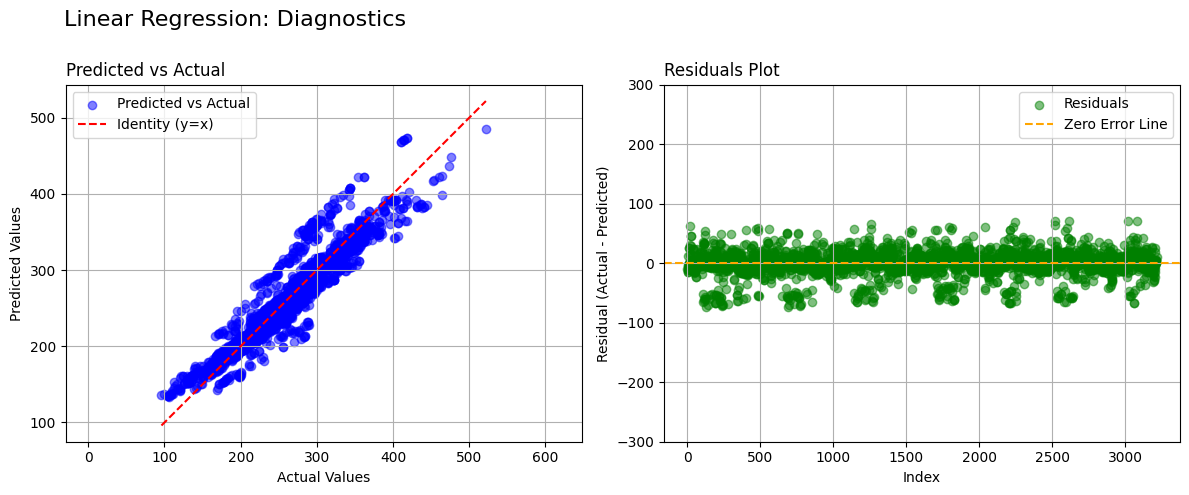

In [6]:
plot_regression_diagnostics(test_y, lr_model.predict(test_set_constant[0]),
                            fig_title="Linear Regression: Diagnostics")

One of the strengths of the model lies in the use of statistical tests to determine the relevance of a feature within the model. The p-values of a unimportant feature takes higher values than 0.1. As seen in the table below, the `Transmission` is irrelevant to the model.

In [7]:
# Coefficients and regression table
print(lr_model.summary().tables[1])

                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                              229.8557      1.180    194.844      0.000     227.543     232.168
Cylinders                            7.4129      0.862      8.604      0.000       5.724       9.102
Engine Size(L)                      10.5028      0.898     11.700      0.000       8.743      12.263
Fuel Consumption City (L/100 km)    21.4669      1.208     17.778      0.000      19.100      23.834
Fuel Consumption Hwy (L/100 km)     18.9142      1.020     18.550      0.000      16.915      20.913
Fuel Type                            9.0273      0.490     18.430      0.000       8.067       9.988
Gears                                2.6064      0.343      7.599      0.000       1.934       3.279
Transmission                         0.0904      0.258      0.350      0.726      -0.416   

### LASSO regression

Although we could perform a stepwise feature selection in the regression model using the p-values, a more direct way is using a **LASSO regression** (Least Absolute Shrinkage and Selection Operator). In it, the fit is optimized using an absolute value function (instead of an squared function) which penalties the absolute values of coefficients promoting sparsity and feature selection.

Those features with smaller, unimportant coefficients are automatically eliminated from the model. Particularly, the removal of `Fuel Type` and `Transmission` does not worsen the accuracies significantly. The inclusion of this variables in the linear regression model would only add noise to the predictions. Even though the MSE values are higher, this model seems to generalize better as the MSE in the test dataset is lower. The diagnostic plots have a similar reading to the previous ones.



In [8]:
print("---- LASSO LINEAR REGRESSION ----")
lasso_model = sm.OLS(train_y, sm.add_constant(train_X)).fit_regularized(L1_wt=1.0, zero_tol=0.5)

# Accuracy measurement
lasso_acc = get_error_measurements(train_set = train_set_constant,
                                test_set = test_set_constant, fitted_model = lasso_model)

print("\nCoefficients: ")
lasso_coeffs_names = train_X.columns.astype('string')
lasso_coeffs_names = lasso_coeffs_names.insert(0, "Inter.")
print(pd.DataFrame([lasso_model.params.tolist()], columns=lasso_coeffs_names))

---- LASSO LINEAR REGRESSION ----
R2 :	Train = 0.8843 		 Test = 0.8834
MSE:	Train = 414.7985 	 Test = 402.5903

Coefficients: 
    Inter.  Cylinders  Engine Size(L)  Fuel Consumption City (L/100 km)  \
0 251.0634    11.0238          9.1704                           21.5806   

   Fuel Consumption Hwy (L/100 km)  Fuel Type  Gears  Transmission  
0                          16.6375     0.0000 3.7348        0.0000  


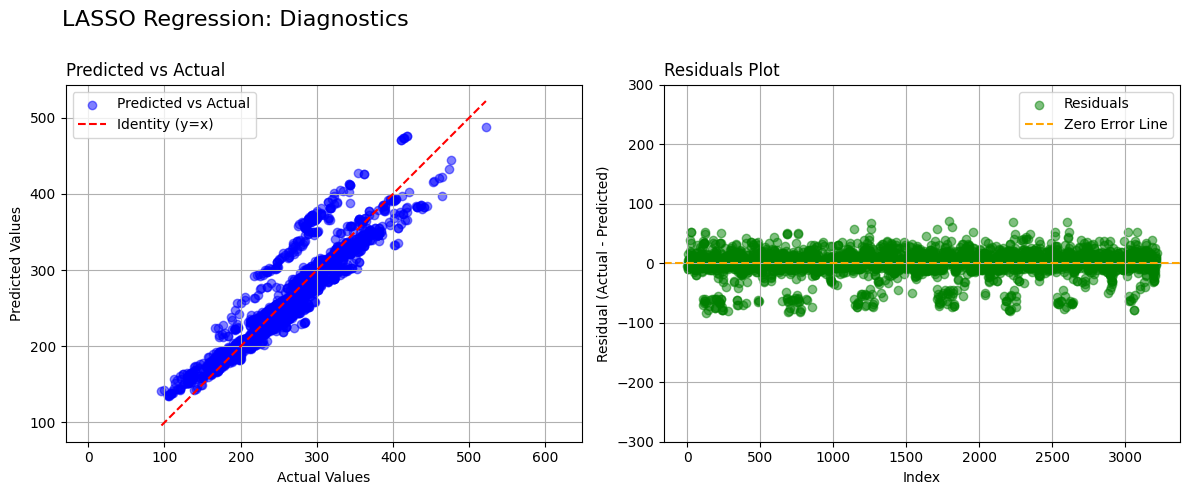

In [9]:
plot_regression_diagnostics(test_y, lasso_model.predict(test_set_constant[0]),
                            fig_title="LASSO Regression: Diagnostics")

### Support Vector Machine (SVM)
Although linear models seem to be capable of predicting the response variable, the previous results show that more complex and powerful models are needed, such as Support Vector Machines (SVM) or Regression Trees.

By finding the optimal hyperplane that best separates data points of different classes, SVM maximizes the margin between the nearest points, known as support vectors, to improve generalization. This technique relies on the assumption that data is linearly predictible in a higher-dimensional space, achieved through kernel functions. SVM's greastest strengths are its robustness, its ability to handle non-linear relationships effectively and having none or few hyperparameters (depending on the kernel). Radial basis functions are used as kernel as it is able to capture complex, non-linear relationships between features (in contrast to the linear kernel) and its tuning is simpler (in the polynomial one, the degree is an hyperparameter which must be tuned to avoid overfitting).

Both the $R^2$ and the MSE values indicate that the fitted SVM model improves the result of the linear regressions and seems to generalize well as its performance in the test dataset is even greater than in the training set. The diagnostic plots highlight that some observations are worse predicted, particularly those in the extremes of the dependent variable's range.

In [10]:
print("---- SVM: RBF Kernel ----")
svm_model = SVR(kernel="rbf").fit(train_X, train_y)
svm_acc = get_error_measurements(train_set = train_set, test_set = test_set, fitted_model = svm_model)

---- SVM: RBF Kernel ----
R2 :	Train = 0.9115 		 Test = 0.9131
MSE:	Train = 317.2072 	 Test = 299.9437


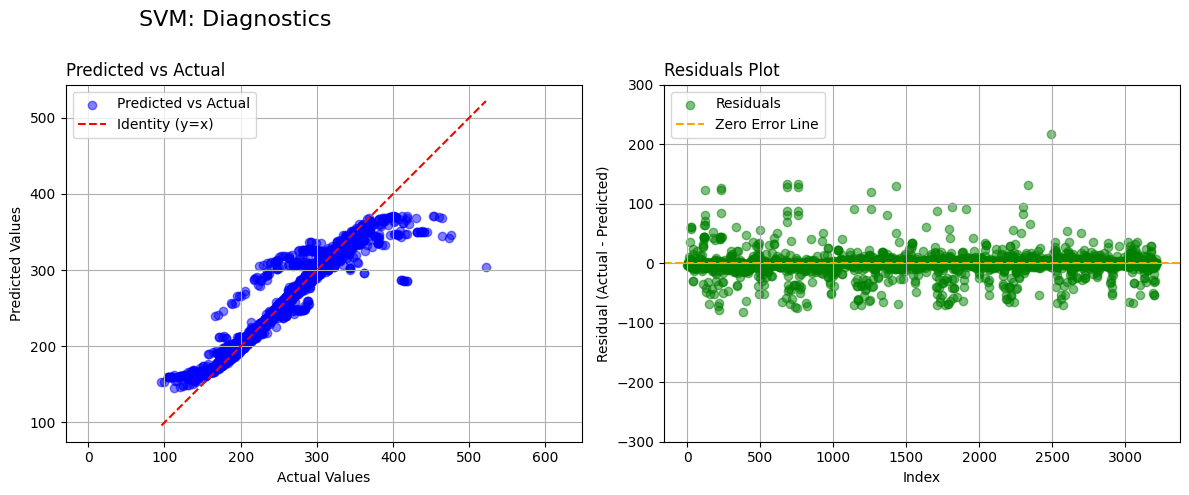

In [11]:
plot_regression_diagnostics(test_y, svm_model.predict(test_X),
                            fig_title="SVM: Diagnostics")

### Regression Trees
Regression tree models are a type of decision tree used to predict continuous outcomes by recursively splitting the data into regions based on feature values. Each split is determined by minimizing the variance within the resulting subsets, creating a tree-like structure where terminal nodes, or leaves, represent the predicted values. This method assumes that relationships between variables can be approximated through piecewise constant functions, making it intuitive and flexible for capturing non-linear patterns. Regression trees are widely used in fields like finance and ecology for their interpretability and ability to handle complex datasets.

The fitted model achieve near perfect accuracy in both datasets, although the notable increase of the MSE in the dataset hint the existence of overfiting. The diagnostic plots remark that there are 4 observations in which the prediction differs from the actual value in more than 50. Overfitting could be mitigated with pruning or ensemble, sample-based techniques like random forests.


In [12]:
print("---- REGRESSION TREES ----")
rt_model = DecisionTreeRegressor(criterion="absolute_error", random_state=0).fit(train_X, train_y)
rt_acc = get_error_measurements(train_set = train_set, test_set = test_set, fitted_model = rt_model)

---- REGRESSION TREES ----
R2 :	Train = 0.9997 		 Test = 0.9929
MSE:	Train = 0.9476 	 Test = 24.5471


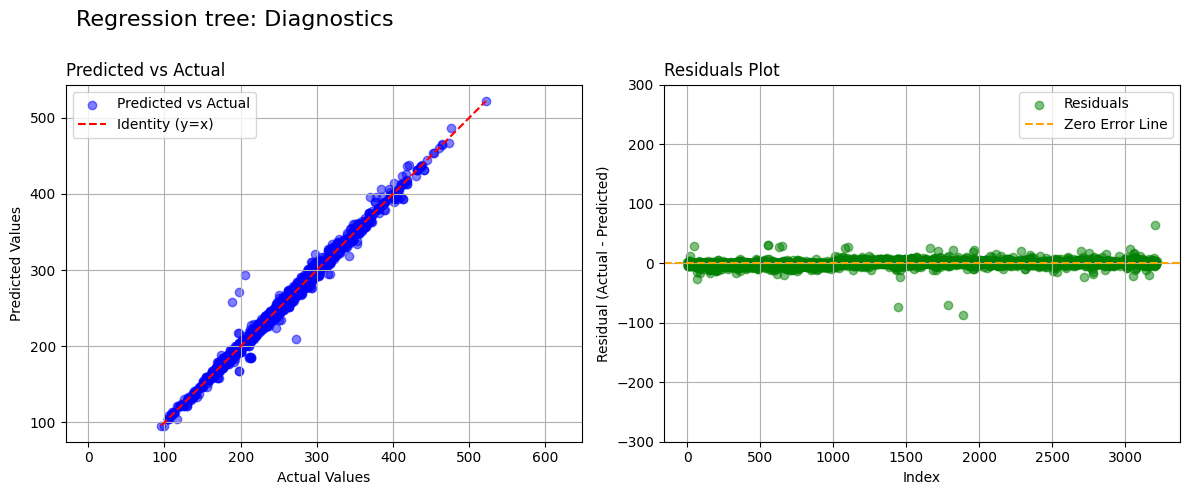

In [13]:
plot_regression_diagnostics(test_y, rt_model.predict(test_X),
                            fig_title="Regression tree: Diagnostics")

The interpretability of tree-based models is one of their greatest strengths. The analysis highlights the relative importance of each feature and the top nodes of the model. Notably, `Fuel Consumption City (L/100 km)` emerges as the most influential variable, with `Fuel Consumption Hwy (L/100 km)` ranking second.

                                  Importance
Cylinders                             0.0082
Engine Size(L)                        0.0082
Fuel Consumption City (L/100 km)      0.8175
Fuel Consumption Hwy (L/100 km)       0.0974
Fuel Type                             0.0593
Gears                                 0.0052
Transmission                          0.0042


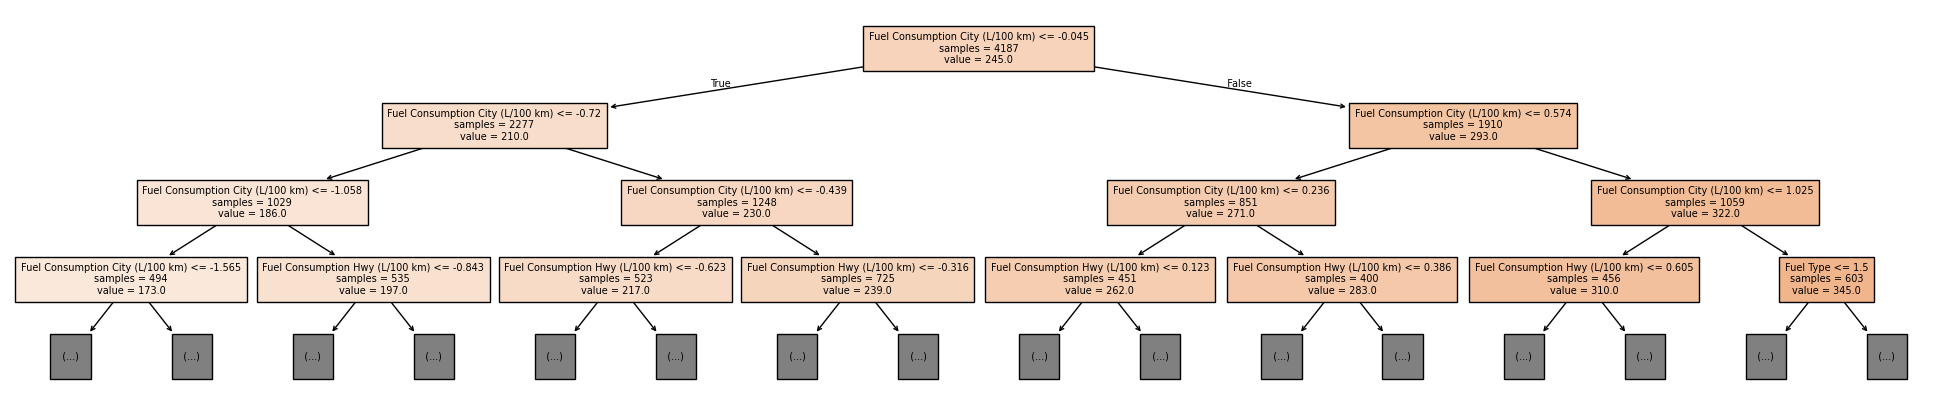

In [14]:
print(pd.DataFrame(rt_model.feature_importances_, index=train_X.columns, columns=["Importance"]))

fig = plt.figure(figsize=(25,5))
_ = plot_tree(rt_model, max_depth=3, feature_names=train_X.columns,
              impurity=False, node_ids=False, filled=True, fontsize=7)

## Discussion and conclusion

In [15]:
# Compilation of the results
model_names = ["Linear Regression", "Linear Regression (LASSO)", "SVM", "Regression Tree"]
train_r2 = [reg_acc["Train-R2"][0], lasso_acc["Train-R2"][0], svm_acc["Train-R2"][0], rt_acc["Train-R2"][0]]
train_mse = [reg_acc["Train-MSE"][0], lasso_acc["Train-MSE"][0], svm_acc["Train-MSE"][0], rt_acc["Train-MSE"][0]]
test_r2 = [reg_acc["Test-R2"][0], lasso_acc["Test-R2"][0], svm_acc["Test-R2"][0], rt_acc["Test-R2"][0]]
test_mse = [reg_acc["Test-MSE"][0], lasso_acc["Test-MSE"][0], svm_acc["Test-MSE"][0], rt_acc["Test-MSE"][0]]
features = [7, 5, 7, 7]

# Join the results in a single dataframe for easier comparison
pd.DataFrame({"Model":model_names, "Features":features, "Train R2":train_r2, "Test R2":test_r2,
              "Train MSE":train_mse, "Test MSE":test_mse})

,Model,Features,Train R2,Test R2,Train MSE,Test MSE
0,Linear Regression,7,0.8935,0.8940,382.0382,366.0219
1,Linear Regression (LASSO),5,0.8843,0.8834,414.7985,402.5903
2,SVM,7,0.9115,0.9131,317.2072,299.9437
3,Regression Tree,7,0.9997,0.9929,0.9476,24.5471


This notebook developed regression models to predict CO2 emissions from vehicles using a preprocessed dataset of 6,281 rows and 7 features, including fuel consumption, engine size, cylinders, gears, fuel type, and transmission. Four models—Linear Regression, LASSO Regression, Support Vector Machine (SVM) with RBF kernel, and Regression Trees—were evaluated to capture relationships between vehicle characteristics and emissions.

The models demonstrated varying levels of performance:
- **Linear Regression** ($R^2$: 0.8935 train, 0.8940 test; MSE: 382.04 train, 366.02 test) provided a solid and interpretable baseline for predicting CO2 emissions. Analysis of p-values indicated that `Transmission` was not a significant predictor. While the model revealed a strong linear relationship between several features and CO2 emissions, this relationship should not be assumed to be strictly linear.
- **LASSO Regression** ($R^2$: 0.8843 train, 0.8834 test; MSE: 414.80 train, 402.59 test) slightly underperformed due to its reduced feature set, indicating that regularization may have oversimplified the model as `Fuel Type` was also supressed from the model. Most of the comments regarding Linear Regression also apply in the LASSO variant.
- **SVM with RBF Kernel** ($R^2$: 0.9115 train, 0.9131 test; MSE: 317.21 train, 299.94 test) struck an optimal balance between performance and generalization, effectively capturing non-linear patterns in the data. However, its lack of interpretability requires advanced techniques for deeper insights.
- **Regression Trees** ($R^2$: 0.9997 train, 0.9929 test; MSE: 0.95 train, 24.55 test) effectively captured non-linear relationships, achieving near-perfect training performance. However, a slight drop in test performance suggests potential overfitting. Feature importance metrics highlighted  `Fuel Consumption City (L/100 km)` as the most influential predictor.

The SVM model emerged as the most robust, offering high accuracy and stable generalization, making it suitable for practical applications like informing vehicle emission regulations or guiding eco-friendly design choices. The regression tree, while highly accurate, could benefit from pruning or ensemble methods like Random Forests to mitigate overfitting.

This analysis underscores the importance of balancing model complexity and generalization. `Fuel Consumption City and Highway (L/100 km)` were key predictors, while `Transmission` had minimal impact, suggesting potential for feature selection. The dataset, limited to Canadian vehicles from 2017–2021, may restrict generalizability to other regions with differing vehicle fleets or driving conditions. Missing features like vehicle weight could further enhance predictions.

Future work could incorporate cross-validation, hyperparameter tuning, or ensemble methods to improve performance. Integrating predictions into environmental policy frameworks would amplify real-world impact. As Part 2 of this portfolio, this notebook demonstrates proficiency in applying machine learning to address a pressing environmental challenge, delivering actionable insights through rigorous model development and evaluation.

### Key Findings
- **Model Performance**: The SVM with RBF kernel achieved the best balance of accuracy and generalization, outperforming Linear Regression, LASSO Regression and Regression Trees.

- **Feature Importance**: The Fuel Consumption in City and Highway were the strongest predictors of CO2 emissions, while Transmission had minimal impact.

- **Model Insights**: SVM and Regression Trees effectively captured non-linear patterns, but Regression Trees showed slight overfitting (test MSE: 24.55 vs. train MSE: 0.95). Linear models confirmed a strong linear relationship but missed some complexity.

- **Dataset Limitations**: The dataset, covering Canadian vehicles from 2017–2021, may limit generalizability due to regional biases and missing features like vehicle weight or driving conditions.


### Future Work and Applications
- Implement cross-validation to ensure robust model evaluation and reduce variance in performance metrics.
- Apply hyperparameter tuning for SVM and ensemble tree-based methods to optimize model accuracy and mitigate overfitting.
- Incorporate additional features (e.g., vehicle weight, driving patterns, ambient temperature) to improve predictive power.
- Expand the dataset to include diverse regions and time periods for broader applicability.
- Explore advanced ensemble methods like Gradient Boosting to enhance performance and interpretability.
- Applications: environmental policies (profile of high-emission vehicle), automotive design (key fetures of eco-friendly vehicles), consumer tools (get sustainable purchasing decisions), among others.
